In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from osgeo import gdal
import pandas as pd
import warnings
import os
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['HarmonyOS Sans SC'] # Wow, Huawei Fonts!
plt.rcParams['font.monospace'] = ['HarmonyOS Sans SC']  # Wow, Huawei Fonts as Mono! (ma lazy)
plt.rcParams['axes.unicode_minus'] = False

data_path = 'assets/Week9/9_HMWRK_NanjingLandsat/'

## 加载数据并计算 NDVI 指数

✓ 成功加载 B1：
  - 尺寸: (7721, 7581)
  - 数据范围: [0.00, 51285.00]
  - 平均值: 6396.81
✓ 成功加载 B2：
  - 尺寸: (7721, 7581)
  - 数据范围: [0.00, 56489.00]
  - 平均值: 6651.15
✓ 成功加载 B3：
  - 尺寸: (7721, 7581)
  - 数据范围: [0.00, 56802.00]
  - 平均值: 7283.84
✓ 成功加载 B4：
  - 尺寸: (7721, 7581)
  - 数据范围: [0.00, 54182.00]
  - 平均值: 7307.51
✓ 成功加载 B5：
  - 尺寸: (7721, 7581)
  - 数据范围: [0.00, 63379.00]
  - 平均值: 9928.98
✓ 成功加载 B6：
  - 尺寸: (7721, 7581)
  - 数据范围: [0.00, 65454.00]
  - 平均值: 9226.68

总共加载 6 个波段

透明度分析:
  - 总像素数: 58,532,901
  - 全透明像素数: 17,831,975 (30.46%)
  - 有效像素数: 40,700,926 (69.54%)

Red Band (B4) 统计 (排除透明像素):
  - 范围: [4224.00, 54182.00]
  - 均值: 10509.10

NIR Band (B5) 统计 (排除透明像素):
  - 范围: [6641.00, 63379.00]
  - 均值: 14279.09

NDVI 计算结果统计 (排除透明像素):
  - 最小值: -0.257752
  - 最大值: 0.650172
  - 平均值: 0.144870
  - 中位数: 0.146055
  - 标准差: 0.094763

植被覆盖分类统计结果（排除透明像素）：

类别              NDVI范围          像素数             比例        
------------------------------------------------------------
非植被/水体          < 0.2           30,016

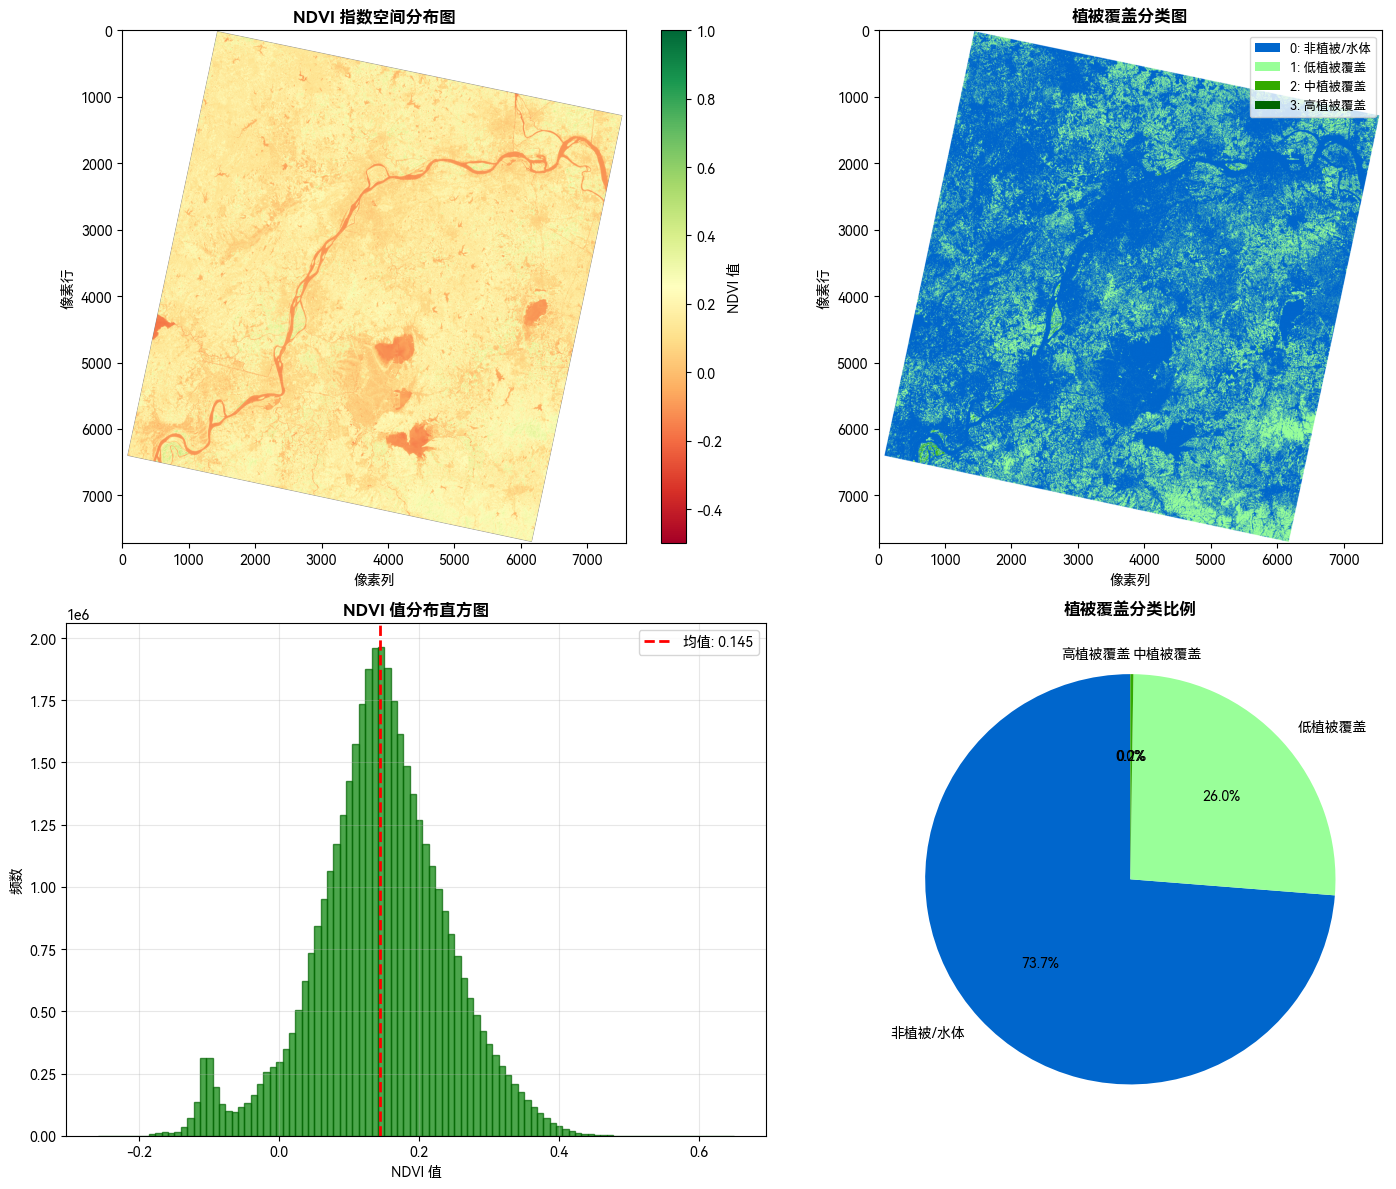

In [2]:
band_files = {
    'B1': data_path + 'LC09_L2SP_120038_20240310_20240311_02_T1_SR_B1.TIF',
    'B2': data_path + 'LC09_L2SP_120038_20240310_20240311_02_T1_SR_B2.TIF',
    'B3': data_path + 'LC09_L2SP_120038_20240310_20240311_02_T1_SR_B3.TIF',
    'B4': data_path + 'LC09_L2SP_120038_20240310_20240311_02_T1_SR_B4.TIF',
    'B5': data_path + 'LC09_L2SP_120038_20240310_20240311_02_T1_SR_B5.TIF',
    'B6': data_path + 'LC09_L2SP_120038_20240310_20240311_02_T1_SR_B6.TIF',
}

def load_band_gdal(band_path):
    try:
        ds = gdal.Open(band_path)
        if ds is None:
            print(f"错误：无法打开 {band_path}")
            return None, None
        
        band = ds.GetRasterBand(1)
        data = band.ReadAsArray().astype(np.float32)
        
        return data, band
    except Exception as e:
        print(f"错误：加载 {band_path} 失败 - {str(e)}")
        return None, None

# 加载所有波段数据
bands_data = {}
bands_obj = {}

for band_name, band_path in band_files.items():
    data, band_obj = load_band_gdal(band_path)
    if data is not None:
        bands_data[band_name] = data
        bands_obj[band_name] = band_obj
        print(f"✓ 成功加载 {band_name}：")
        print(f"  - 尺寸: {data.shape}")
        print(f"  - 数据范围: [{np.min(data):.2f}, {np.max(data):.2f}]")
        print(f"  - 平均值: {np.mean(data):.2f}")
    else:
        print(f"✗ 加载 {band_name} 失败")

print(f"\n总共加载 {len(bands_data)} 个波段")

# 获取红光波段 (B4) 和近红外波段 (B5)
if 'B4' in bands_data and 'B5' in bands_data:
    red = bands_data['B4']
    nir = bands_data['B5']
    
    # 创建有效像素掩膜（排除全透明像素）
    valid_mask = (red > 0) | (nir > 0)
    transparent_pixels = np.sum(~valid_mask)
    total_pixels = red.size
    
    print(f"\n透明度分析:")
    print(f"  - 总像素数: {total_pixels:,}")
    print(f"  - 全透明像素数: {transparent_pixels:,} ({(transparent_pixels/total_pixels)*100:.2f}%)")
    print(f"  - 有效像素数: {np.sum(valid_mask):,} ({(np.sum(valid_mask)/total_pixels)*100:.2f}%)")
    
    print(f"\nRed Band (B4) 统计 (排除透明像素):")
    print(f"  - 范围: [{np.min(red[valid_mask]):.2f}, {np.max(red[valid_mask]):.2f}]")
    print(f"  - 均值: {np.mean(red[valid_mask]):.2f}")
    
    print(f"\nNIR Band (B5) 统计 (排除透明像素):")
    print(f"  - 范围: [{np.min(nir[valid_mask]):.2f}, {np.max(nir[valid_mask]):.2f}]")
    print(f"  - 均值: {np.mean(nir[valid_mask]):.2f}")
    
    # NDVI计算公式: NDVI = (NIR - Red) / (NIR + Red)
    denominator = nir + red
    denominator[denominator == 0] = 1e-8
    
    # 计算 NDVI
    ndvi = (nir - red) / denominator
    
    # 对透明像素设置无效值
    ndvi[~valid_mask] = np.nan
    
    print(f"\nNDVI 计算结果统计 (排除透明像素):")
    print(f"  - 最小值: {np.nanmin(ndvi):.6f}")
    print(f"  - 最大值: {np.nanmax(ndvi):.6f}")
    print(f"  - 平均值: {np.nanmean(ndvi):.6f}")
    print(f"  - 中位数: {np.nanmedian(ndvi):.6f}")
    print(f"  - 标准差: {np.nanstd(ndvi):.6f}")
    
else:
    print("错误：缺少 B4 或 B5 波段")
    ndvi = None
    valid_mask = None

if ndvi is not None and valid_mask is not None:
    # 创建分类数组
    vegetation_class = np.full_like(ndvi, 255, dtype=np.uint8)  # 255表示无效像素
    
    # 只对有效像素进行分类
    vegetation_class[valid_mask & (ndvi < 0.2)] = 0
    vegetation_class[valid_mask & (ndvi >= 0.2) & (ndvi < 0.4)] = 1
    vegetation_class[valid_mask & (ndvi >= 0.4) & (ndvi < 0.6)] = 2
    vegetation_class[valid_mask & (ndvi >= 0.6)] = 3
    
    # 分类标签
    class_labels = ['非植被/水体', '低植被覆盖', '中植被覆盖', '高植被覆盖']
    class_colors = ['#0066CC', '#99FF99', '#33AA00', '#006600']
    
    # 统计各类像素（只统计有效像素）
    print(f"\n植被覆盖分类统计结果（排除透明像素）：\n")
    print(f"{'类别':<15} {'NDVI范围':<15} {'像素数':<15} {'比例':<10}")
    print("-" * 60)
    
    valid_pixels = np.sum(valid_mask)
    classification_stats = {}
    
    for i in range(4):
        count = np.sum(vegetation_class == i)
        percentage = (count / valid_pixels) * 100
        classification_stats[i] = {
            'count': count,
            'percentage': percentage,
            'label': class_labels[i]
        }
        
        if i == 0:
            ndvi_range = "< 0.2"
        elif i == 1:
            ndvi_range = "[0.2, 0.4)"
        elif i == 2:
            ndvi_range = "[0.4, 0.6)"
        else:
            ndvi_range = "≥ 0.6"
        
        print(f"{class_labels[i]:<15} {ndvi_range:<15} {count:<15,} {percentage:<9.2f}%")
    
    print(f"\n有效像素数: {valid_pixels:,}")
    print(f"植被覆盖总比例: {(classification_stats[1]['percentage'] + classification_stats[2]['percentage'] + classification_stats[3]['percentage']):.2f}%")
    
    # 创建图表
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 图1：NDVI 热力图（透明像素显示为白色）
    ndvi_display = np.copy(ndvi)
    im1 = axes[0, 0].imshow(ndvi_display, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
    axes[0, 0].set_title('NDVI 指数空间分布图', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('像素列')
    axes[0, 0].set_ylabel('像素行')
    cbar1 = plt.colorbar(im1, ax=axes[0, 0])
    cbar1.set_label('NDVI 值', fontsize=10)
    
    # 图2：植被覆盖分类图
    cmap_veg = ListedColormap(class_colors + ['white'])
    im2 = axes[0, 1].imshow(vegetation_class, cmap=cmap_veg, vmin=0, vmax=4)
    axes[0, 1].set_title('植被覆盖分类图', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('像素列')
    axes[0, 1].set_ylabel('像素行')
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=class_colors[i], label=f"{i}: {class_labels[i]}") 
                       for i in range(4)]
    axes[0, 1].legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    # 图3：NDVI 分布直方图（排除NaN值）
    ndvi_flat = ndvi[valid_mask]
    axes[1, 0].hist(ndvi_flat, bins=100, color='green', alpha=0.7, edgecolor='darkgreen')
    axes[1, 0].set_title('NDVI 值分布直方图', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('NDVI 值')
    axes[1, 0].set_ylabel('频数')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axvline(np.mean(ndvi_flat), color='red', linestyle='--', linewidth=2, label=f'均值: {np.mean(ndvi_flat):.3f}')
    axes[1, 0].legend()
    
    # 图4：植被覆盖比例饼图
    sizes = [classification_stats[i]['percentage'] for i in range(4)]
    axes[1, 1].pie(sizes, labels=class_labels, autopct='%1.1f%%',
                   colors=class_colors, startangle=90)
    axes[1, 1].set_title('植被覆盖分类比例', fontsize=12, fontweight='bold')

    os.makedirs('wk9-results', exist_ok=True)

    plt.tight_layout()
    plt.savefig('wk9-results/NDVI_Classification_Analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 保存关键数据
    analysis_data = {
        'ndvi': ndvi,
        'red': red,
        'nir': nir,
        'vegetation_class': vegetation_class,
        'classification_stats': classification_stats,
        'bands_obj': bands_obj,
        'bands_data': bands_data,
        'valid_mask': valid_mask
    }
    
else:
    print("无法进行分类，因为 NDVI 计算失败")

## 植被覆盖情况分类

Red Band (B4) 直方图分析：
  ✓ NumPy histogram()（精确值）:
    - 直方图桶数: 256
    - 最大频数: 3410975
    - 最小频数: 0
    - 总频数: 40700926
    - 数据范围: [4224.00, 54182.00]

NIR Band (B5) 直方图分析：
  ✓ NumPy histogram()（精确值）:
    - 直方图桶数: 256
    - 最大频数: 1984997
    - 最小频数: 0
    - 总频数: 40700926
    - 数据范围: [6641.00, 63379.00]

NDVI 直方图分析：
  ✓ NumPy histogram()（精确值）:
    - 直方图桶数: 100
    - 最大频数: 1962893
    - 最小频数: 0
    - 总频数: 40700926
    - 数据范围: [-0.257752, 0.650172]


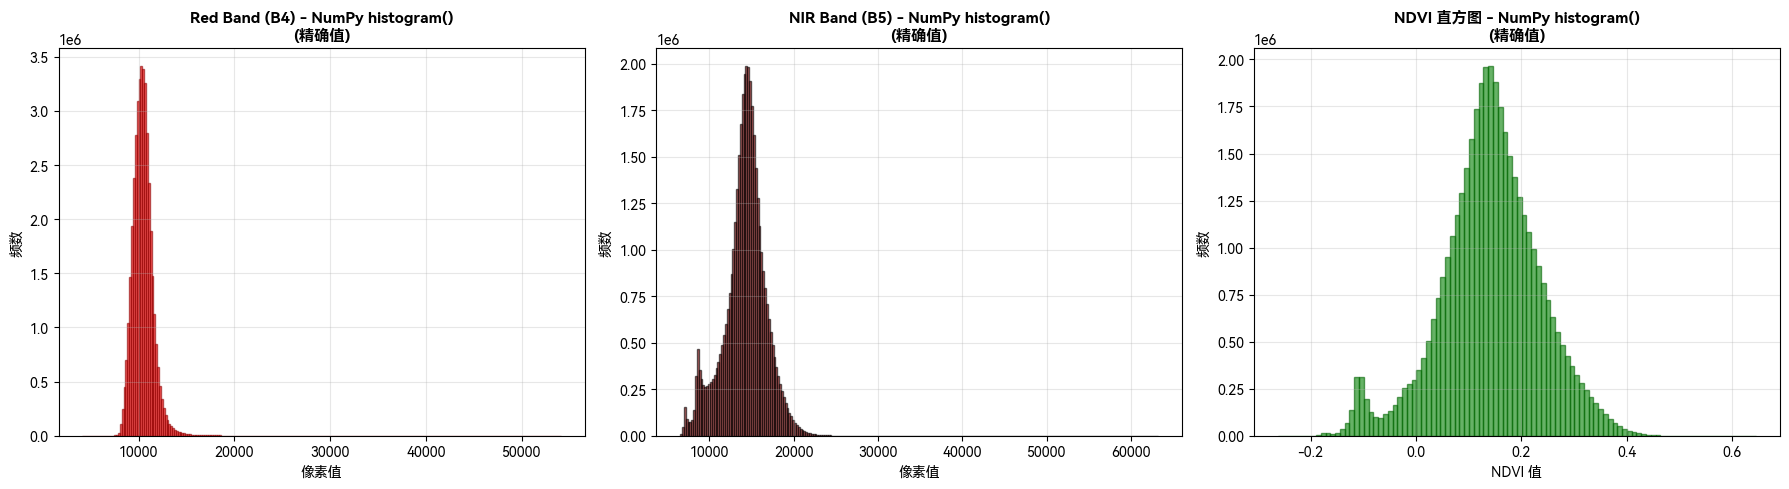


南京地区 Landsat 卫星影像 - NumPy 直方图分析报告

1. 数据信息
   - 卫星: Landsat 9
   - 获取日期: 2024-03-10
   - 处理等级: L2SP (地表反射率)
   - 影像尺寸: (7721, 7581)

2. Red Band (B4) 统计
   • 数据范围: [4224.00, 54182.00]
   • 平均值: 10509.10
   • 标准差: 1056.01
   • 直方图最大频数: 3410975
   • 直方图最小频数: 0

3. NIR Band (B5) 统计
   • 数据范围: [6641.00, 63379.00]
   • 平均值: 14279.09
   • 标准差: 2498.90
   • 直方图最大频数: 1984997
   • 直方图最小频数: 0

4. NDVI 统计
   • 数据范围: [-0.257752, 0.650172]
   • 平均值: 0.144870
   • 标准差: 0.094763
   • 最大频数: 1962893
   • 最小频数: 0

    类别     NDVI范围      像素数     比例(%)
非植被/水体      < 0.2 30016912 73.749949
 低植被覆盖 [0.2, 0.4) 10586784 26.011162
 中植被覆盖 [0.4, 0.6)    97229  0.238886
 高植被覆盖      ≥ 0.6        1  0.000002
      波段         最小值          最大值          平均值         标准差          中位数
Red (B4) 4224.000000 54182.000000 10509.096680 1056.010376 10435.000000
NIR (B5) 6641.000000 63379.000000 14279.088867 2498.899414 14470.000000
    NDVI   -0.257752     0.650172     0.144870    0.094763     0.146055


In [3]:
# Red Band (B4) 直方图
print("Red Band (B4) 直方图分析：")
b4_flat = analysis_data['red'][analysis_data['valid_mask']]
b4_flat = b4_flat[~np.isnan(b4_flat)]
hist_numpy_b4, bins_numpy_b4 = np.histogram(b4_flat, bins=256)
print("  ✓ NumPy histogram()（精确值）:")
print(f"    - 直方图桶数: {len(hist_numpy_b4)}")
print(f"    - 最大频数: {np.max(hist_numpy_b4)}")
print(f"    - 最小频数: {np.min(hist_numpy_b4)}")
print(f"    - 总频数: {np.sum(hist_numpy_b4)}")
print(f"    - 数据范围: [{np.min(b4_flat):.2f}, {np.max(b4_flat):.2f}]")

# NIR Band (B5) 直方图
print("\nNIR Band (B5) 直方图分析：")
b5_flat = analysis_data['nir'][analysis_data['valid_mask']]
b5_flat = b5_flat[~np.isnan(b5_flat)]
hist_numpy_b5, bins_numpy_b5 = np.histogram(b5_flat, bins=256)
print("  ✓ NumPy histogram()（精确值）:")
print(f"    - 直方图桶数: {len(hist_numpy_b5)}")
print(f"    - 最大频数: {np.max(hist_numpy_b5)}")
print(f"    - 最小频数: {np.min(hist_numpy_b5)}")
print(f"    - 总频数: {np.sum(hist_numpy_b5)}")
print(f"    - 数据范围: [{np.min(b5_flat):.2f}, {np.max(b5_flat):.2f}]")

# NDVI 直方图
print("\nNDVI 直方图分析：")
ndvi_flat = analysis_data['ndvi'][analysis_data['valid_mask']]
ndvi_flat = ndvi_flat[~np.isnan(ndvi_flat)]
hist_numpy_ndvi, bins_numpy_ndvi = np.histogram(ndvi_flat, bins=100)
print("  ✓ NumPy histogram()（精确值）:")
print(f"    - 直方图桶数: {len(hist_numpy_ndvi)}")
print(f"    - 最大频数: {np.max(hist_numpy_ndvi)}")
print(f"    - 最小频数: {np.min(hist_numpy_ndvi)}")
print(f"    - 总频数: {np.sum(hist_numpy_ndvi)}")
print(f"    - 数据范围: [{np.min(ndvi_flat):.6f}, {np.max(ndvi_flat):.6f}]")

# 绘图（仅 NumPy）
fig_hist, ax_hist = plt.subplots(1, 3, figsize=(18, 5))

# Red Band (B4)
ax_hist[0].bar(bins_numpy_b4[:-1], hist_numpy_b4, width=np.diff(bins_numpy_b4),
               color='red', alpha=0.6, edgecolor='darkred')
ax_hist[0].set_title('Red Band (B4) - NumPy histogram()\n(精确值)', fontsize=11, fontweight='bold')
ax_hist[0].set_xlabel('像素值')
ax_hist[0].set_ylabel('频数')
ax_hist[0].grid(True, alpha=0.3)

# NIR Band (B5)
ax_hist[1].bar(bins_numpy_b5[:-1], hist_numpy_b5, width=np.diff(bins_numpy_b5),
               color='darkred', alpha=0.6, edgecolor='black')
ax_hist[1].set_title('NIR Band (B5) - NumPy histogram()\n(精确值)', fontsize=11, fontweight='bold')
ax_hist[1].set_xlabel('像素值')
ax_hist[1].set_ylabel('频数')
ax_hist[1].grid(True, alpha=0.3)

# NDVI
ax_hist[2].bar(bins_numpy_ndvi[:-1], hist_numpy_ndvi, width=np.diff(bins_numpy_ndvi),
               color='green', alpha=0.6, edgecolor='darkgreen')
ax_hist[2].set_title('NDVI 直方图 - NumPy histogram()\n(精确值)', fontsize=11, fontweight='bold')
ax_hist[2].set_xlabel('NDVI 值')
ax_hist[2].set_ylabel('频数')
ax_hist[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('wk9-results/Histogram_Analysis_NumPy.png', dpi=300, bbox_inches='tight')
plt.show()

# 报告（仅基于 NumPy）
summary_report = f"""
{'='*70}
南京地区 Landsat 卫星影像 - NumPy 直方图分析报告
{'='*70}

1. 数据信息
   - 卫星: Landsat 9
   - 获取日期: 2024-03-10
   - 处理等级: L2SP (地表反射率)
   - 影像尺寸: {analysis_data['red'].shape}

2. Red Band (B4) 统计
   • 数据范围: [{np.min(b4_flat):.2f}, {np.max(b4_flat):.2f}]
   • 平均值: {np.mean(b4_flat):.2f}
   • 标准差: {np.std(b4_flat):.2f}
   • 直方图最大频数: {np.max(hist_numpy_b4)}
   • 直方图最小频数: {np.min(hist_numpy_b4)}

3. NIR Band (B5) 统计
   • 数据范围: [{np.min(b5_flat):.2f}, {np.max(b5_flat):.2f}]
   • 平均值: {np.mean(b5_flat):.2f}
   • 标准差: {np.std(b5_flat):.2f}
   • 直方图最大频数: {np.max(hist_numpy_b5)}
   • 直方图最小频数: {np.min(hist_numpy_b5)}

4. NDVI 统计
   • 数据范围: [{np.min(ndvi_flat):.6f}, {np.max(ndvi_flat):.6f}]
   • 平均值: {np.mean(ndvi_flat):.6f}
   • 标准差: {np.std(ndvi_flat):.6f}
   • 最大频数: {np.max(hist_numpy_ndvi)}
   • 最小频数: {np.min(hist_numpy_ndvi)}
"""
print(summary_report)

# 保存报告
with open('wk9-results/Histogram_Analysis_Report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

# 分类统计表
classification_df = pd.DataFrame({
    '类别': [analysis_data['classification_stats'][i]['label'] for i in range(4)],
    'NDVI范围': ['< 0.2', '[0.2, 0.4)', '[0.4, 0.6)', '≥ 0.6'],
    '像素数': [analysis_data['classification_stats'][i]['count'] for i in range(4)],
    '比例(%)': [analysis_data['classification_stats'][i]['percentage'] for i in range(4)]
})
classification_df.to_csv('wk9-results/Classification_Statistics.csv', index=False, encoding='utf-8-sig')
print(classification_df.to_string(index=False))

# 波段统计表
band_stats_df = pd.DataFrame({
    '波段': ['Red (B4)', 'NIR (B5)', 'NDVI'],
    '最小值': [np.min(b4_flat), np.min(b5_flat), np.min(ndvi_flat)],
    '最大值': [np.max(b4_flat), np.max(b5_flat), np.max(ndvi_flat)],
    '平均值': [np.mean(b4_flat), np.mean(b5_flat), np.mean(ndvi_flat)],
    '标准差': [np.std(b4_flat), np.std(b5_flat), np.std(ndvi_flat)],
    '中位数': [np.median(b4_flat), np.median(b5_flat), np.median(ndvi_flat)]
})
band_stats_df.to_csv('wk9-results/Band_Statistics.csv', index=False, encoding='utf-8-sig')
print(band_stats_df.to_string(index=False))
